**Analysis of High Dimensional Data**

*Kidney Transplantation Prediction*

Toghrul Jafarov

2018

# Table of Contents
* [Import Packages](#import)
* [Read in Data](#read)
* [Partition dataset into train / test sets](#parition)
* [Solving imbalance class problem](#imbalance)
* [PCA](#pca)
* [Find the most important genes](#imp_genes)
* [Modelling & Hyperparameter Optimization](#modelling)
* [RandomForest](#rf)
* [Logistic regression](#lr)
* [Summary of Modelling](#summary)
* [Ensemble learning](#ensemble)

# Import packages <a class="anchor" id="import"></a>

All the packages and functions that are required to perform this analysis is located on the `utils.py` file.

In [1]:
%matplotlib inline
%run utils.py # import packages and functions
from IPython.display import Image # add image to Jupyter notebook

# Read in dataset <a class="anchor" id="read"></a>

**R** programming language was used to convert `rda` files  into `csv` format. R script located in the project folder `data_transformation.r`.

`read_genes` function allows us to read genes and rejection status from `csv` files and join them based on `Patient_ID`.

In [2]:
# location of the files
genes_file = '../input/geneExporession.csv'
reject_file = '../input/rejectionStatus.csv'

# read files and combine them into one dataframe
genes = read_genes(genes_file, reject_file)

Let's look at some basic statistics about `genes` dataframe.

In [3]:
# basic statistics
print('Gene Expression dimemsion : ', genes.shape)

# colum names of Gene Expression dataframe
print(genes.columns)

Gene Expression dimemsion :  (282, 54676)
Index(['1007_s_at', '1053_at', '117_at', '121_at', '1255_g_at', '1294_at',
       '1316_at', '1320_at', '1405_i_at', '1431_at',
       ...
       'AFFX-r2-Ec-bioD-5_at', 'AFFX-r2-P1-cre-3_at', 'AFFX-r2-P1-cre-5_at',
       'AFFX-ThrX-3_at', 'AFFX-ThrX-5_at', 'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at',
       'AFFX-TrpnX-5_at', 'AFFX-TrpnX-M_at', 'Reject_Status'],
      dtype='object', length=54676)


Dataframe consists of **282** observations and **54676** features. We have high dimensional dataframe where `features >> observations`. Column names indicate gene names, which will be used to identify the most important genes.

In [4]:
# show first 5 observations of dataframe
genes.head()

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at,Reject_Status
0,-0.509888,0.907285,-0.426397,0.620394,0.815133,-1.558944,-2.294462,-0.029182,-0.375581,-0.565908,...,-0.798925,-0.329573,-0.353009,0.120279,-0.090073,0.223092,-0.462811,-0.535511,-0.945590,0
1,2.099274,0.472717,-0.970433,1.939885,1.389738,-0.808953,-0.151921,-1.465310,-0.531330,-0.671876,...,0.918052,1.614725,1.682336,-0.899223,-1.082886,-1.094667,-1.420273,1.936127,0.564888,0
2,1.515065,0.861931,-0.095270,0.119333,-1.291400,1.238506,-0.792613,-1.551733,0.958593,-0.068830,...,0.122643,-0.151553,-0.243025,0.704425,0.321570,0.643790,-0.502623,0.958246,-0.213871,0
3,-1.670543,-1.042448,-0.195428,-0.798114,-0.367502,-0.056506,-0.875353,-1.698253,-0.638380,-0.788331,...,0.246163,-0.357388,-0.459229,0.141840,-0.388244,-0.387571,1.158516,-1.424770,0.644184,0
4,-0.266156,-1.221776,-1.089340,0.227828,-0.499106,-1.990728,-1.764210,-0.537985,-1.429030,-0.542326,...,-0.659528,-0.681865,-1.014025,-0.744076,-0.798634,-0.786791,-1.645905,1.179429,0.454224,0


# Partition dataset into train / test sets <a class="anchor" id="partition"></a>

In order to test the performance of the model and evaluate the model by using Cross-validation, original dataset was spitted into train and test sets. As the classes are imbalanced, `Stratified Shuffle Split` is used, which shuffles the data each time before splitting (randomized folds). The same class balance for test and train datasets is preserved. 

Train set contains 70% (197), test set 30% (85) of original data. 

After splitting original data, class balance is: 
* 1) train data 0 (accept) = **73.1%**, 1 (reject) = **26.9%**
* 2) test data 0 (accept) = **72.9%**, 1(reject) = **27.1%**

In [5]:
# seperate predictors and target variable
X = genes.loc[:, :'Reject_Status']
y = genes.Reject_Status

In [6]:
# initialize Stratified splitting
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1)

# loop over each split and assign values on different variables
for train_index, test_index in sss.split(X, y):
    
    train_df = genes.loc[list(train_index), :] # train data frame for up/down sampling
    
    X_train = X.loc[list(train_index), :] # train features w/o sampling
    X_test  = X.loc[list(test_index), :] # test features
    y_train = y[train_index] # train target w/o sampling
    y_test  = y[test_index] # test target

In [7]:
print('Train dataset class distribution:')
print(y_train.value_counts(normalize=True) * 100)

print('\nTest dataset class distribution:')
print(y_test.value_counts(normalize=True) * 100)

Train dataset class distribution:
0    73.096447
1    26.903553
Name: Reject_Status, dtype: float64

Test dataset class distribution:
0    72.941176
1    27.058824
Name: Reject_Status, dtype: float64


# Solving imbalance class problem <a class="anchor" id="imbalance"></a>

Imbalanced class dataset can increase model accuracy artificially. In our case without any machine learning model, predicting 0 (accept) each time we can get 73% of accuracy.

* **Up-sampling** is the process of randomly duplicating observations from the minority class in order to reinforce its signal. The most common way is to simply resample with replacement.

* **Down-sampling** involves randomly removing observations from the majority class to prevent its signal dominating the learning algorithm.  The most common heuristic is resampling without replacement.

After resampling original dataset the  ratio of the two classes is now 1:1.

But the number of the observations is different:
* Original Data     : *197*
* Down-sampled Data : *108*
* Up-sampled Data   : *288*

In [8]:
# create train data frame for up and down sampling
print('Down sampling\n')
X_train_down, y_train_down = balance_classes(train_df, balance='down') # down sampling
print('Up sampling\n')
X_train_up, y_train_up = balance_classes(train_df, balance='up') # up sampling

Down sampling

Class balance : 
1    53
0    53
Name: Reject_Status, dtype: int64
Up sampling

Class balance : 
1    144
0    144
Name: Reject_Status, dtype: int64


# PCA <a class="anchor" id="pca"></a>

## Choosing optimal number of components

In order to find out the optimal number of principal components, KNN and Logistic Regression have been tested with different values of principal components (3, 5, 7, 9), and with different values of the prediction model parameters. For both models 9 principal components were the best.

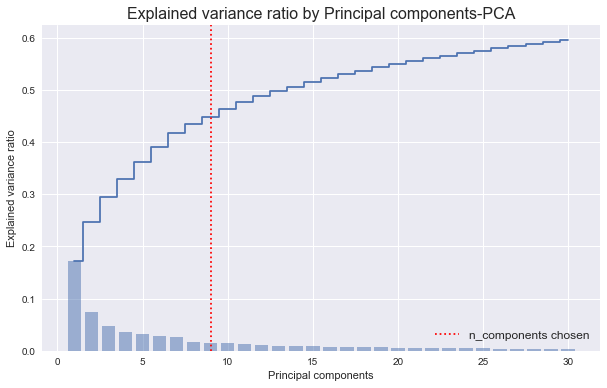

In [9]:
# explained variance ratio with cumulative sum
pca = PCA(n_components=30, random_state=1)
X_pca = pca.fit_transform(X.values)

# plot cumulative variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, 31), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.title('Explained variance ratio by Principal components-PCA', fontsize=16)
plt.step(range(1, 31), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.axvline(9, linestyle=':', label='n_components chosen', c='red')
plt.legend(prop=dict(size=12))

plt.savefig('../figures/explained_var_ratio.png')
plt.show()

On the above figure:
* *Histogram*: explained variance of each component
* *Blue line*: cumulative explained variance ratio
* *Red dotted* line: optimal number of components

## Plot of variability of the classes

Following figure shows gene variation associated with kidney rejection. On the x-axes first principal component, on the y-axes second principal component were used. We can observe from the figure that there is highly variance for each class.

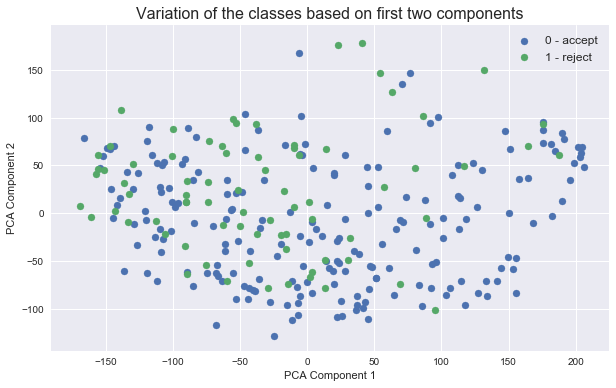

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='0 - accept')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='1 - reject')

plt.title('Variation of the classes based on first two components', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(loc='best', prop=dict(size=12))

plt.savefig('../figures/variation_classes_pca.png')
plt.show()

# Find the most important `genes`. <a class="anchor" id="imp_genes"></a>

In order to find out the most important genes in predicting the kidney rejection, **cosine similarity** is used. After performing PCA on the original dataset, cosine similarity is calculated between first principal component and all genes. Genes with high similarity are the important most ones or explains the most variance. We used first principal component, because it explains the most variance ratio about dataset.

In [11]:
# get first component from PCA
comp = X_pca[:, 0]

In [12]:
# find top 10 similar genes / columns
top_index, top_columns, top_similarity = important_genes(X, comp)

In [13]:
# the most important columns / genes
top_columns

['206362_x_at',
 '239565_at',
 '220538_at',
 '225211_at',
 '213441_x_at',
 '221099_at',
 '232367_x_at',
 '241486_at',
 '229496_at',
 '220962_s_at']

In [14]:
# corresponding similarity for important genes
top_similarity

[0.8445145100282964,
 0.8315247992097108,
 0.8303961900084451,
 0.8208045965949589,
 0.8111385853551566,
 0.8055341924729429,
 0.8054272510065696,
 0.8049396093587725,
 0.8033270086685911,
 0.802821098532412]

# Modelling & Hyperparameter Optimization <a class="anchor" id="modelling"></a>

Three type of classification algorithms have been used for this analysis: `Random Forest`, `Logistic Regression` and `K-Nearest Neighborhood (KNN)`. Principal Component Analysis (PCA) applied to reduce the dimensionality as well. Before performing any transformation and modelling data has been scaled to zero mean and unit variance.

To sum up, we have 3 different versions of the same data: `original data`, `up-sampled data` and `down-sampled data`; and 3 classification models.

We tried to understand which dataset and classification model perform better on kidney rejection problem. 

Apart from **ROC AUC** metric, **confusion matrix, precision and recall** measures are used to assess the classification performance.


Now we have **three** different dataset:
* X_train, y_train (original)
* X_train_up, y_train_up (up-sampled)
* X_train_down, y_train_down (down_sampled)

`Pipeline` from *skleanr* package is used to specify each step of the execution. Pipeline allows us to specify preprocessing and modelling functions, which will execute consequtively. For KNN example it will look like:

```python
pipe_knn = Pipeline(steps=[
    ('scl', StandardScaler()), # scale the matrix
    ('pca', PCA(n_components=2, random_state=1)), # reduce the dimensionality
    ('knn', KNeighborsClassifier(n_neighbors=4, p=2, metric='minkowski', n_jobs=-1)) # perform KNN
])
```

Afterwards we a dictionary of possible value to explore for each step of the Pipeline. On the following example, we want to explore as a principal component ```python [3, 5, 7]``` and as number of neighbors for KNN ```python [3, 4, 5]```.

```python
param_grid = [
    {
        'pca__n_components': [3, 5, 7],
        'knn__n_neighbors': [3, 4, 5]
    }
]
```

`GridSearchCV` is used in order to explore all the combination of the values by evaluating *3-folds Cross-validation* each time. `ROC AUC` is used as a metric.

```python
estimator = GridSearchCV(
        pipe_knn,
        cv=StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=1), # preserve class balance
        param_grid=param_grid,
        scoring='roc_auc',
        n_jobs=-1
    )
```

This process is repeated for each dataset and classification model.

## K-Nearest Neighborhood <a class="anchor" id="knn"></a>

In [15]:
# possible values for parameters to explore
n_components = [3, 5, 7, 9]
neighbors = range(2, 5)

# initialize the Pipeline
pipe_knn = Pipeline(steps=[
    ('scl', StandardScaler()), # scale the matrix
    ('pca', PCA(n_components=2, random_state=1)), # reduce the dimensionality
    ('knn', KNeighborsClassifier(n_neighbors=4, p=2, metric='minkowski', n_jobs=-1)) # perform KNN
])

# param_grid - contains possible value to explore for different steps on the Pipeline
param_grid = [
    {
        'pca__n_components': n_components,
        'knn__n_neighbors': neighbors
    }
]

#### Without sampling

Training AUC : 0.704
Best Parameters :  {'knn__n_neighbors': 3, 'pca__n_components': 9}


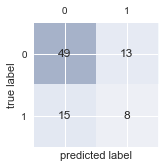

             precision    recall  f1-score   support

          0       0.77      0.79      0.78        62
          1       0.38      0.35      0.36        23

avg / total       0.66      0.67      0.67        85



In [16]:
# find optimal parameters
estimator_knn = find_optimal_param(X_train, y_train, X_test, y_test, pipe_knn, param_grid)

## Confusion matrix & classification report
# get prediction
y_pred_knn_label_wo_samp = estimator_knn.predict(X_test)
y_pred_knn_prob_wo_samp = estimator_knn.predict_proba(X_test)

# print confusion matrix and classification report
classifier_stats(y_true=y_test, y_pred=y_pred_knn_label_wo_samp)

#### Down sampling

Training AUC : 0.634
Best Parameters :  {'knn__n_neighbors': 2, 'pca__n_components': 9}


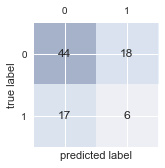

             precision    recall  f1-score   support

          0       0.72      0.71      0.72        62
          1       0.25      0.26      0.26        23

avg / total       0.59      0.59      0.59        85



In [17]:
# find optimal parameters
estimator_knn = find_optimal_param(X_train_down, y_train_down, X_test, y_test, pipe_knn, param_grid)

## Confusion matrix & classification report
# get prediction
y_pred_knn_label_down_samp = estimator_knn.predict(X_test)
y_pred_knn_prob_down_samp = estimator_knn.predict_proba(X_test)

# print confusion matrix and classification report
classifier_stats(y_true=y_test, y_pred=y_pred_knn_label_down_samp)

#### Up sampling

Training AUC : 0.836
Best Parameters :  {'knn__n_neighbors': 2, 'pca__n_components': 9}


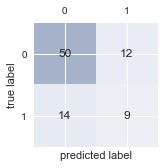

             precision    recall  f1-score   support

          0       0.78      0.81      0.79        62
          1       0.43      0.39      0.41        23

avg / total       0.69      0.69      0.69        85



In [18]:
# find optimal parameters
estimator_knn = find_optimal_param(X_train_up, y_train_up, X_test, y_test, pipe_knn, param_grid)

## Confusion matrix & classification report
# get prediction
y_pred_knn_label_up_samp = estimator_knn.predict(X_test)
y_pred_knn_prob_up_samp = estimator_knn.predict_proba(X_test)

# print confusion matrix and classification report
classifier_stats(y_true=y_test, y_pred=y_pred_knn_label_up_samp)

## RandomForest <a class="anchor" id="rf"></a>

In [19]:
pipe_rf = Pipeline(steps=[
    ('pca', PCA(n_components=9, random_state=1)),
    ('knn', RandomForestClassifier(n_estimators=20, max_depth=2, min_samples_leaf=3, n_jobs=-1))
])

# use a full grid over all parameters
param_grid = [
    {
        'knn__n_estimators': [40, 60, 80, 100],
        'knn__max_depth': [3, 4, 5],
        'knn__min_samples_leaf' : [3, 4, 5]
    }
]

#### Without sampling

Training AUC : 0.809
Best Parameters :  {'knn__max_depth': 3, 'knn__min_samples_leaf': 4, 'knn__n_estimators': 60}


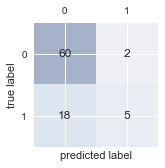

             precision    recall  f1-score   support

          0       0.77      0.97      0.86        62
          1       0.71      0.22      0.33        23

avg / total       0.75      0.76      0.72        85



In [20]:
# find optimal parameters
estimator_rf = find_optimal_param(X_train, y_train, X_test, y_test, pipe_rf, param_grid)

## Confusion matrix & classification report
# get prediction
y_pred_rf_label_wo_samp = estimator_rf.predict(X_test)
y_pred_rf_prob_wo_samp = estimator_rf.predict_proba(X_test)

# print confusion matrix and classification report
classifier_stats(y_true=y_test, y_pred=y_pred_rf_label_wo_samp)

#### Down sampling

Training AUC : 0.693
Best Parameters :  {'knn__max_depth': 3, 'knn__min_samples_leaf': 4, 'knn__n_estimators': 80}


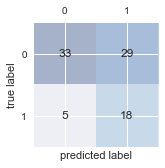

             precision    recall  f1-score   support

          0       0.87      0.53      0.66        62
          1       0.38      0.78      0.51        23

avg / total       0.74      0.60      0.62        85



In [21]:
# find optimal parameters
estimator_rf = find_optimal_param(X_train_down, y_train_down, X_test, y_test, pipe_rf, param_grid)

## Confusion matrix & classification report
# get prediction
y_pred_rf_label_down_samp = estimator_rf.predict(X_test)
y_pred_rf_prob_down_samp = estimator_rf.predict_proba(X_test)

# print confusion matrix and classification report
classifier_stats(y_true=y_test, y_pred=y_pred_rf_label_down_samp)

#### Up sampling

Training AUC : 0.914
Best Parameters :  {'knn__max_depth': 5, 'knn__min_samples_leaf': 3, 'knn__n_estimators': 40}


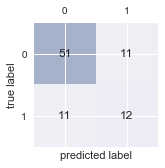

             precision    recall  f1-score   support

          0       0.82      0.82      0.82        62
          1       0.52      0.52      0.52        23

avg / total       0.74      0.74      0.74        85



In [22]:
# find optimal parameters
estimator_rf = find_optimal_param(X_train_up, y_train_up, X_test, y_test, pipe_rf, param_grid)

## Confusion matrix & classification report
# get prediction
y_pred_rf_label_up_samp = estimator_rf.predict(X_test)
y_pred_rf_prob_up_samp = estimator_rf.predict_proba(X_test)

# print confusion matrix and classification report
classifier_stats(y_true=y_test, y_pred=y_pred_rf_label_up_samp)

## Logistic regression <a class="anchor" id="lr"></a>

In [23]:
# possible values for parameters

n_components = [3, 5, 7, 9]
c = [0.001, 0.01, 0.1, 1.0]

pipe_lr = Pipeline(steps=[
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=9, random_state=1)),
    ('lr', LogisticRegression(penalty='l2', C=0.001, random_state=0, n_jobs=-1, ))
])

# use a full grid over all parameters
param_grid = [
    {
        'pca__n_components': n_components,
        'lr__penalty': ['l1', 'l2'],
        'lr__C': c
    }
]

#### Without sampling

Training AUC : 0.818
Best Parameters :  {'lr__C': 0.001, 'lr__penalty': 'l2', 'pca__n_components': 9}


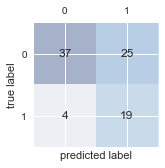

             precision    recall  f1-score   support

          0       0.90      0.60      0.72        62
          1       0.43      0.83      0.57        23

avg / total       0.78      0.66      0.68        85



In [24]:
# find optimal parameters
estimator_lr = find_optimal_param(X_train, y_train, X_test, y_test, pipe_lr, param_grid)

## Confusion matrix & classification report
# get prediction
y_pred_lr_label_wo_samp = estimator_lr.predict(X_test)
y_pred_lr_prob_wo_samp = estimator_lr.predict_proba(X_test)

# print confusion matrix and classification report
classifier_stats(y_true=y_test, y_pred=y_pred_lr_label_wo_samp)

#### Down sampling

Training AUC : 0.732
Best Parameters :  {'lr__C': 0.1, 'lr__penalty': 'l1', 'pca__n_components': 9}


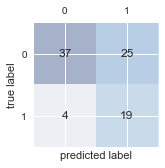

             precision    recall  f1-score   support

          0       0.90      0.60      0.72        62
          1       0.43      0.83      0.57        23

avg / total       0.78      0.66      0.68        85



In [25]:
# find optimal parameters
estimator_lr = find_optimal_param(X_train_down, y_train_down, X_test, y_test, pipe_lr, param_grid)

## Confusion matrix & classification report
# get prediction
y_pred_lr_label_down_samp = estimator_lr.predict(X_test)
y_pred_lr_prob_down_samp = estimator_lr.predict_proba(X_test)

# print confusion matrix and classification report
classifier_stats(y_true=y_test, y_pred=y_pred_lr_label_down_samp)

#### Up sampling

Training AUC : 0.732
Best Parameters :  {'lr__C': 0.1, 'lr__penalty': 'l1', 'pca__n_components': 9}


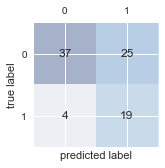

             precision    recall  f1-score   support

          0       0.90      0.60      0.72        62
          1       0.43      0.83      0.57        23

avg / total       0.78      0.66      0.68        85



In [26]:
# find optimal parameters
estimator_lr = find_optimal_param(X_train_down, y_train_down, X_test, y_test, pipe_lr, param_grid)

## Confusion matrix & classification report
# get prediction
y_pred_lr_label_up_samp = estimator_lr.predict(X_test)
y_pred_lr_prob_up_samp = estimator_lr.predict_proba(X_test)

# print confusion matrix and classification report
classifier_stats(y_true=y_test, y_pred=y_pred_lr_label_up_samp)

## Summary of Modelling <a class="anchor" id="summary"></a>

Here is the list of the optimal parameters for each dataset and classification models. These parameters are used for the further analysis: prediction and ensemble learning.

```python
KNN
original {'knn__n_neighbors': 3, 'pca__n_components': 9}
down {'knn__n_neighbors': 2, 'pca__n_components': 9}
up {'knn__n_neighbors': 2, 'pca__n_components': 9}

Random Forest
original {'knn__max_depth': 4, 'knn__min_samples_leaf': 5, 'knn__n_estimators': 80}
down {'knn__max_depth': 3, 'knn__min_samples_leaf': 5, 'knn__n_estimators': 40}
up {'knn__max_depth': 5, 'knn__min_samples_leaf': 3, 'knn__n_estimators': 100}

Logistic Regression
original {'lr__C': 0.001, 'lr__penalty': 'l2', 'pca__n_components': 9}
down {'lr__C': 0.1, 'lr__penalty': 'l1', 'pca__n_components': 9}
up {'lr__C': 0.1, 'lr__penalty': 'l1', 'pca__n_components': 9}
```


### Generate each model with optimal parameter values

In [27]:
## Random Forest
# without sampling
rf_wo_pipe = Pipeline(steps=[
    ('pca', PCA(n_components=9, random_state=1)),
    ('knn', RandomForestClassifier(n_estimators=80, max_depth=4, min_samples_leaf=5, n_jobs=-1, random_state=1))
])
rf_wo = rf_wo_pipe.fit(X_train, y_train)

# down sampling
rf_down_pipe = Pipeline(steps=[
    ('pca', PCA(n_components=9, random_state=1)),
    ('knn', RandomForestClassifier(n_estimators=40, max_depth=3, min_samples_leaf=5, n_jobs=-1, random_state=1))
])
rf_down = rf_down_pipe.fit(X_train_down, y_train_down)

# up sampling
rf_up_pipe = Pipeline(steps=[
    ('pca', PCA(n_components=9, random_state=1)),
    ('knn', RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_leaf=3, n_jobs=-1, random_state=1))
])
rf_up = rf_up_pipe.fit(X_train_up, y_train_up)

In [28]:
## Logistic Regression
# without
lr_wo_pipe = Pipeline(steps=[
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=9, random_state=1)),
    ('lr', LogisticRegression(penalty='l2', C=0.001, random_state=0, n_jobs=-1))
])

lr_wo = lr_wo_pipe.fit(X_train, y_train)

# down / up sampling
lr_down_pipe = Pipeline(steps=[
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=9, random_state=1)),
    ('lr', LogisticRegression(penalty='l1', C=0.1, random_state=0, n_jobs=-1))
])
lr_down = lr_down_pipe.fit(X_train_down, y_train_down)

lr_up_pipe = Pipeline(steps=[
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=9, random_state=1)),
    ('lr', LogisticRegression(penalty='l1', C=0.1, random_state=0, n_jobs=-1))
])
lr_up = lr_up_pipe.fit(X_train_up, y_train_up)

In [29]:
## KNN
# without sampling
knn_wo_pipe = Pipeline(steps=[
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=9, random_state=1)),
    ('knn', KNeighborsClassifier(n_neighbors=3, p=2, metric='minkowski', n_jobs=-1))
])
knn_wo = knn_wo_pipe.fit(X_train, y_train)

# down sampling
knn_down_pipe = Pipeline(steps=[
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=9, random_state=1)),
    ('knn', KNeighborsClassifier(n_neighbors=2, p=2, metric='minkowski', n_jobs=-1))
])
knn_down = knn_down_pipe.fit(X_train_down, y_train_down)

# up sampling
knn_up_pipe = Pipeline(steps=[
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=9, random_state=1)),
    ('knn', KNeighborsClassifier(n_neighbors=2, p=2, metric='minkowski', n_jobs=-1))
])
knn_up = knn_up_pipe.fit(X_train_up, y_train_up)

In [30]:
# list of the predictive models with corresponding labels
clf_labels = ['RF w/o', 'RF down', 'RF up', 'LR w/o', 'LR down', 'LR up', 'KNN w/o', 'KNN down', 'KNN up']
all_clf    = [rf_wo, rf_down, rf_up, lr_wo, lr_down, lr_up, knn_wo, knn_down, knn_up]

`ROC AUC` metric for each models.

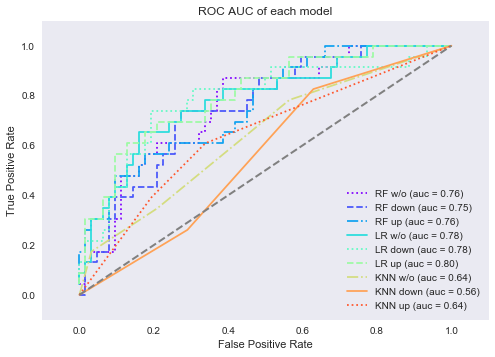

In [31]:
linestyles = [':', '--', '-.', '-', ':', '--', '-.', '-', ':']
colors = iter(plt.cm.rainbow(np.linspace(0, 1, 10)))

for clf, label, ls in zip(all_clf, clf_labels, linestyles):
    
    # assuming the label of the positive class is 1
    y_pred = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=next(colors),
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.title('ROC AUC of each model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# plt.tight_layout()
plt.savefig('../figures/roc.png', dpi=300)
plt.show()

# Ensemble learning <a class="anchor" id="ensemble"></a>

Until now we had 9 models to predict kidney rejection. Instead of choosing one as a final model, we can combine their predictions into one data frame and perform another meta model on it. In order to evaluate the model performance, we split test data into test and validation datasets (`80%` and `20%` respectively). 

Pseudo code of Ensemble Learning:
```python
* For each dataset (original, up / down sampled) apply classification models (RF, LR, KNN)
* Get probability prediction for test data from each model (9 model on total, so data frame with 9 columns and number of rows on test dataset observations)
* Perform another meta-model (Random Forest) on probability prediction to predict kidney rejection (probability predictions as predictors and kidney rejection as target variable)
```

Following figure shows the steps of the Ensemble Learning.

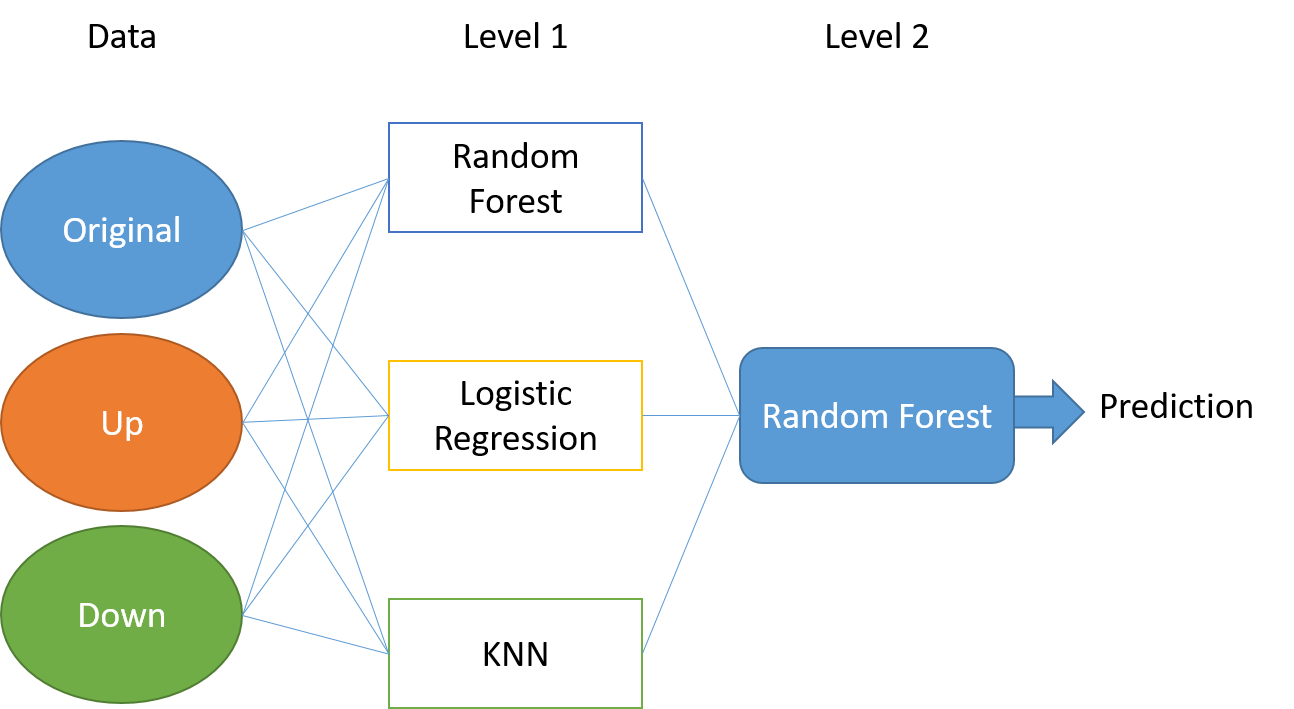

In [32]:
Image("../figures/Ensemble Learning.png")

Split test dataset into test and validation sets, in order to test Ensemble Learning model performance.

In [33]:
# initialize Stratified splitting
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=1)

for train_index, test_index in sss.split(X_test, y_test):
    
    X_test = X.loc[list(train_index), :] # train features w/o sampling
    X_val  = X.loc[list(test_index), :] # test features
    y_test = y[train_index] # train target w/o sampling
    y_val  = y[test_index] # test target

`ensemble_prediction` function allows us to get **probability prediction** of each model (in total 9) for test data.

In [34]:
_, ensemble = ensemble_prediction(X_test, all_clf, clf_labels, ens_type='prob')

After getting probability prediction dataframe, perform `meta-model` on it, in order to train a classification model to predict kidney rejection from probability prediction of 9 models.

`GridSearchCV` is used to find the optimal parameter for `Random Forest`.

In [35]:
pipe_last = Pipeline(steps=[
    ('knn', RandomForestClassifier(n_estimators=20, max_depth=2, min_samples_leaf=3, class_weight={0: 0.4, 1: 0.6}, n_jobs=-1))
])

# use a full grid over all parameters
param_grid = [
    {
        'knn__n_estimators': [40, 60, 80, 100],
        'knn__max_depth': [3, 4, 5],
        'knn__min_samples_leaf' : [3, 4, 5]
    }
]

# last is the random forest model with the best parameters from GridSearch
last = find_optimal_param(ensemble.values, y_test, ensemble.values, y_test, pipe_last, param_grid)

Training AUC : 0.963
Best Parameters :  {'knn__max_depth': 5, 'knn__min_samples_leaf': 3, 'knn__n_estimators': 100}


Now we have meta-model and in order to evaluate the performance `validation` dataset will be used.

In [36]:
# get probability prediction of 9 models for validation dataset
_, ensemble_pred = ensemble_prediction(X_val, all_clf, clf_labels, ens_type='prob')

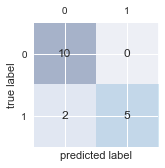

             precision    recall  f1-score   support

          0       0.83      1.00      0.91        10
          1       1.00      0.71      0.83         7

avg / total       0.90      0.88      0.88        17



In [37]:
# get label prediction from meta model based on probability prediction
meta_model_pred = last.predict(ensemble_pred)

# get classification statistics
classifier_stats(y_pred=meta_model_pred, y_true=y_val)

Calculate `ROC AUC` metric for validation dataset.

In [38]:
y_pred = last.predict_proba(ensemble_pred)[:, 1]
fpr, tpr, thresholds = roc_curve(y_true=y_val,
                                 y_score=y_pred)
roc_auc = auc(x=fpr, y=tpr)
print('Validation AUC : %.3f' % roc_auc)

Validation AUC : 1.000
